In [1]:
import math
import numpy as np
import scipy
import h5py
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization  
from tensorflow.keras.layers import Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from matplotlib.pyplot import imshow

In [2]:
def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. we'll need this later to add back to the main path. 
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', 
               name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', 
               name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', 
               name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [3]:
def convolutional_block(X, f, filters, stage, block, s=2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    # First component of main path 
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [4]:
def ResNet50(input_shape, outputClasses):
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3 
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL 
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(outputClasses, activation='softmax', name='fc' + str(outputClasses), 
              kernel_initializer=glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [5]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split


def load_dataset(image_dir, target_size=(64, 64)):
    class_names = os.listdir(image_dir)  # List all subfolders (classes)
    images = []
    labels = []
    
    class_counts = {}  # Dictionary to store the count of images per class
    
    # Loop through each class folder
    for label, class_name in enumerate(class_names):
        class_folder = os.path.join(image_dir, class_name)
        
        if os.path.isdir(class_folder):  # Make sure it's a directory
            image_filenames = os.listdir(class_folder)
            class_counts[class_name] = len(image_filenames)  # Count the number of images in the folder
            
            # Loop through each image in the class folder
            for filename in image_filenames:
                image_path = os.path.join(class_folder, filename)
                
                # Load and resize the image
                try:
                    image = Image.open(image_path)
                    image = image.resize(target_size)  # Resize the image
                    # Convert image to numpy array
                    image_array = np.array(image)
                    
                    # Append the image and its label
                    images.append(image_array)
                    labels.append(label)  # Assign the folder index as the label
                except Exception as e:
                    print(f"Error loading image {image_path}: {e}")
    
    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)
    
    # Print the number of images for each class
    for class_name, count in class_counts.items():
        print(f"Class '{class_name}' has {count} images.")
    
    # Print the shape of images and labels before splitting
    print(f"Shape of images: {images.shape}")
    print(f"Shape of labels: {labels.shape}")
    
    # Split the dataset into training and testing sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test, class_names

# Define your path
image_dir = r"C:\Users\Ahmed Atef\OneDrive\Desktop\archive\As"

# Load dataset and split into train/test
X_train, X_test, y_train, y_test, class_names = load_dataset(image_dir)

# Print the shape of X_train and y_train after the split
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

Class 'pins_alycia dabnem carey' has 211 images.
Class 'pins_Bill Gates' has 122 images.
Class 'pins_Christian Bale' has 154 images.
Class 'pins_Cristiano Ronaldo' has 98 images.
Class 'pins_elon musk' has 135 images.
Class 'pins_Lionel Messi' has 86 images.
Shape of images: (806, 64, 64, 3)
Shape of labels: (806,)
Shape of X_train: (644, 64, 64, 3)
Shape of y_train: (644,)


In [6]:
# Normalize image vectors
X_train = X_train / 255.
X_test = X_test / 255.

In [7]:
def convert_to_one_hot(Y, C):
    Y = Y.astype(int)  # Ensure that the labels are integers
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

# Convert y_train and y_test to one-hot encoded labels
y_train = convert_to_one_hot(y_train, 6).T
y_test = convert_to_one_hot(y_test, 6).T

# Check shapes after one-hot encoding
print(f"Shape of y_train after one-hot encoding: {y_train.shape}")
print(f"Shape of y_test after one-hot encoding: {y_test.shape}")

Shape of y_train after one-hot encoding: (644, 6)
Shape of y_test after one-hot encoding: (162, 6)


In [10]:
model = ResNet50(input_shape=(64, 64, 3), outputClasses=6)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 64, 64, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_1              │ (None, 70, 70, 3)         │               0 │ input_layer_1[0][0]        │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1 (Conv2D)                │ (None, 32, 32, 64)        │           9,472 │ zero_padding2d_1[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_conv1 (BatchNormalization) │ (None, 32, 32, 64)        │             256 │ conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_49 (Activation)    │ (None, 32, 32, 64)        │               0 │ bn_conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 15, 15, 64)        │               0 │ activation_49[0][0]        │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ res2a_branch2a (Conv2D)       │ (None, 15, 15, 64)        │           4,160 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn2a_branch2a                 │ (None, 15, 15, 64)        │             256 │ res2a_branch2a[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_50 (Activation)    │ (None, 15, 15, 64)        │               0 │ bn2a_branch2a[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ res2a_branch2b (Conv2D)       │ (None, 15, 15, 64)        │          36,928 │ activation_50[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn2a_branch2b                 │ (None, 15, 15, 64)        │             256 │ res2a_branch2b[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_51 (Activation)    │ (None, 15, 15, 64)        │               0 │ bn2a_branch2b[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ res2a_branch2c (Conv2D)       │ (None, 15, 15, 256)       │          16,640 │ activation_51[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ res2a_branch1 (Conv2D)        │ (None, 15, 15, 256)       │          16,640 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn2a_branch2c                 │ (None, 15, 15, 256)       │           1,024 │ res2a_branch2c[0][0]       │
│ (BatchNormalization)          │                           │               

 Total params: 23,600,006 (90.03 MB)

 Trainable params: 23,546,886 (89.82 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [11]:
model.fit(X_train, y_train, epochs=5, batch_size=32)

Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.1703 - loss: 4.7907
Epoch 2/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.3833 - loss: 2.1418
Epoch 3/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.4608 - loss: 1.8312
Epoch 4/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.6428 - loss: 1.1693
Epoch 5/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.7580 - loss: 1.2011


In [12]:
preds = model.evaluate(X_test, y_test)
print("Test Loss = " + str(preds[0]))
print("Test Accuracy = " + str(preds[1]))

6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 590ms/step - accuracy: 0.1888 - loss: 2.7064
Test Loss = 2.709669828414917
Test Accuracy = 0.1975308656692505


6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step 
y_pred shape: (162,)
y_test_labels shape: (162,)
Confusion Matrix:
[[ 7 34  0  0  0  0]
 [ 1 25  0  0  0  0]
 [ 2 33  0  0  0  0]
 [ 0 17  0  0  0  0]
 [ 0 24  0  0  0  0]
 [ 1 18  0  0  0  0]]


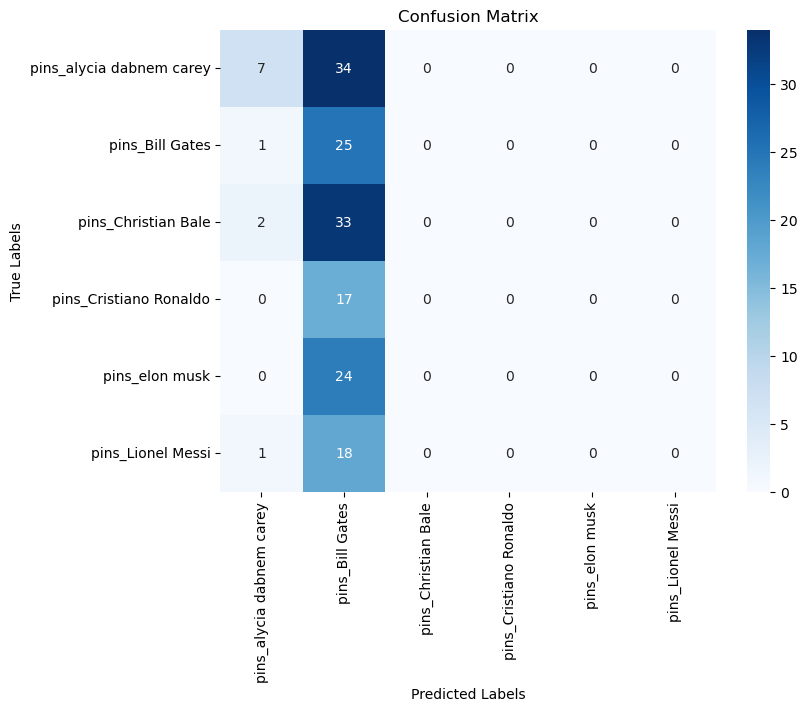

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# After training the model, predict on the test set
y_pred_prob = model.predict(X_test)  # Get predicted probabilities for each class

# Convert probabilities to class labels (the index of the max probability)
y_pred = np.argmax(y_pred_prob, axis=1)

# Convert one-hot encoded y_test back to class labels
y_test_labels = np.argmax(y_test, axis=1)

# Ensure y_pred and y_test_labels are both 1D arrays containing class labels (not one-hot encoded)
print("y_pred shape:", y_pred.shape)  # Should be (num_test_samples,)
print("y_test_labels shape:", y_test_labels.shape)  # Should be (num_test_samples,)

# Compute confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix using seaborn (ensure it's a square matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [19]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(y_true, y_preds, y_probs, class_names):
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names,
                cbar=False, annot_kws={"size": 14}, linewidths=1.5, linecolor='black')
    plt.xlabel("Predicted", fontsize=16)
    plt.ylabel("True", fontsize=16)
    plt.title("Confusion Matrix", fontsize=18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_true, y_preds, target_names=class_names))

    # Precision, Recall, F-Score Visualization
    report = classification_report(y_true, y_preds, target_names=class_names, output_dict=True)
    precision = [report[class_name]['precision'] for class_name in class_names]
    recall = [report[class_name]['recall'] for class_name in class_names]
    f1_score = [report[class_name]['f1-score'] for class_name in class_names]

    x = np.arange(len(class_names))  # class indices
    width = 0.2

    plt.figure(figsize=(10, 7))
    plt.bar(x - width, precision, width, label='Precision', color='skyblue')
    plt.bar(x, recall, width, label='Recall', color='lightgreen')
    plt.bar(x + width, f1_score, width, label='F1-Score', color='salmon')

    plt.xlabel('Classes', fontsize=14)
    plt.ylabel('Scores', fontsize=14)
    plt.title('Precision, Recall, F1-Score by Class', fontsize=16)
    plt.xticks(x, class_names, fontsize=12)
    plt.legend(fontsize=12)
    plt.show()

    # ROC and AUC Visualization
    plt.figure(figsize=(10, 7))
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true == i, y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label="Random Guess")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curve by Class', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True)
    plt.show()


In [20]:
y_probs = model.predict(X_test)  # Predicted probabilities

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step


In [21]:
y_preds = np.argmax(y_probs, axis=1)  # Predicted class labels

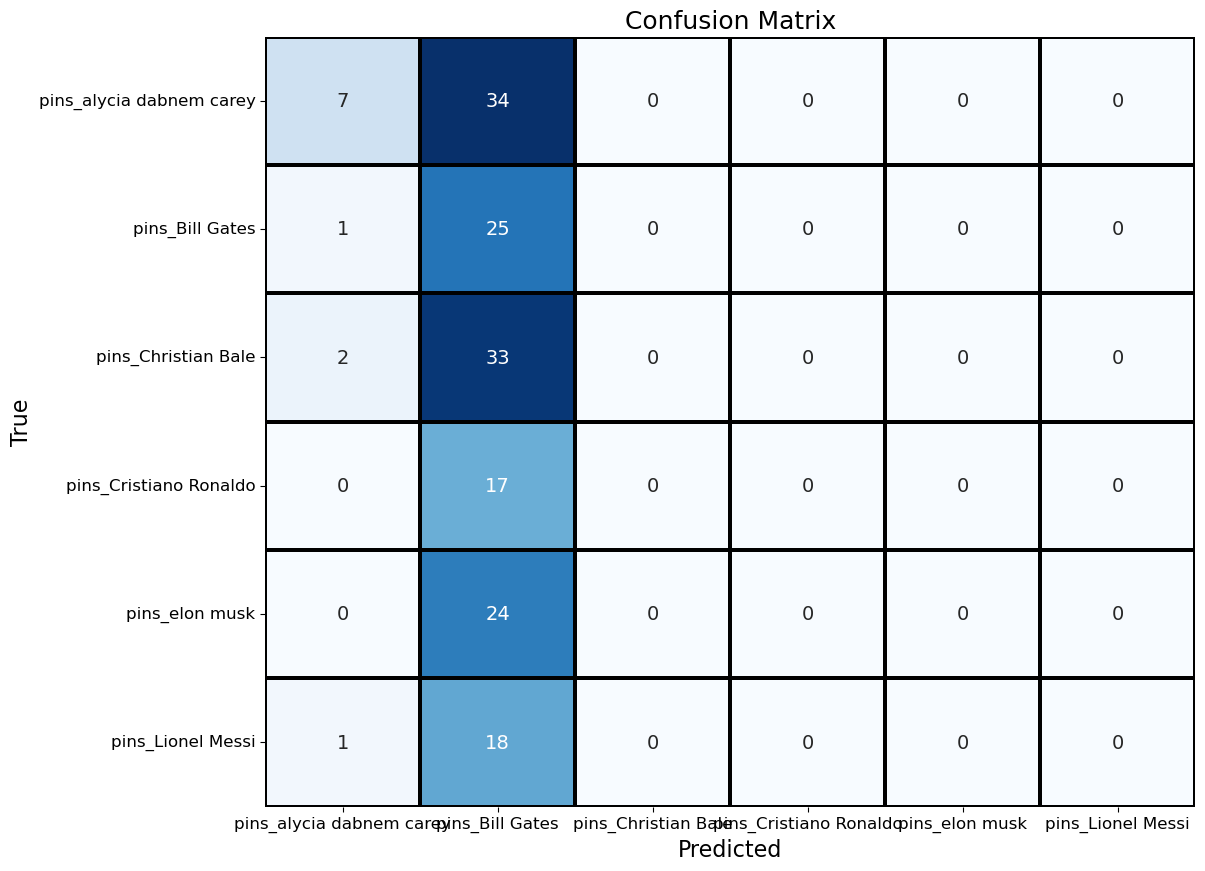

Classification Report:
                          precision    recall  f1-score   support

pins_alycia dabnem carey       0.64      0.17      0.27        41
         pins_Bill Gates       0.17      0.96      0.28        26
     pins_Christian Bale       0.00      0.00      0.00        35
  pins_Cristiano Ronaldo       0.00      0.00      0.00        17
          pins_elon musk       0.00      0.00      0.00        24
       pins_Lionel Messi       0.00      0.00      0.00        19

                accuracy                           0.20       162
               macro avg       0.13      0.19      0.09       162
            weighted avg       0.19      0.20      0.11       162



D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: Undefine

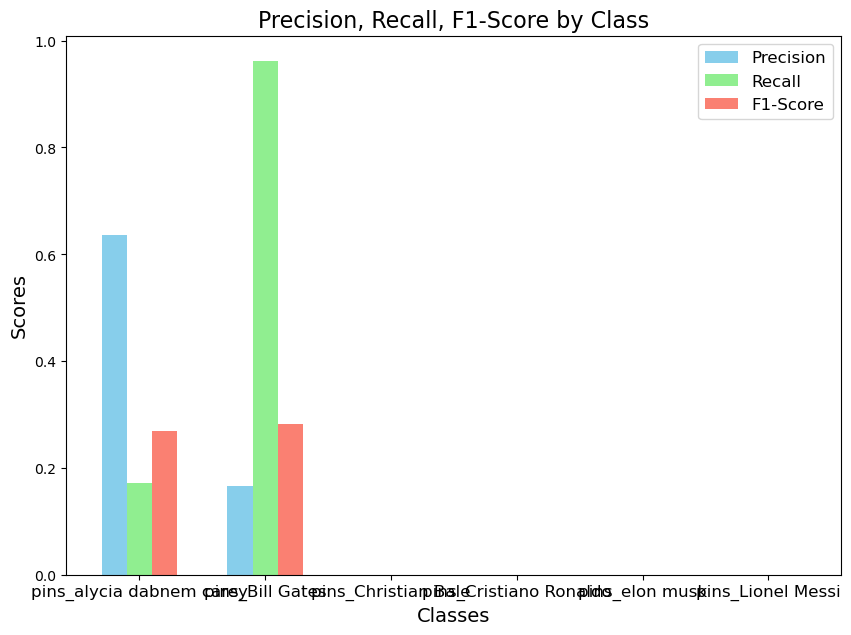

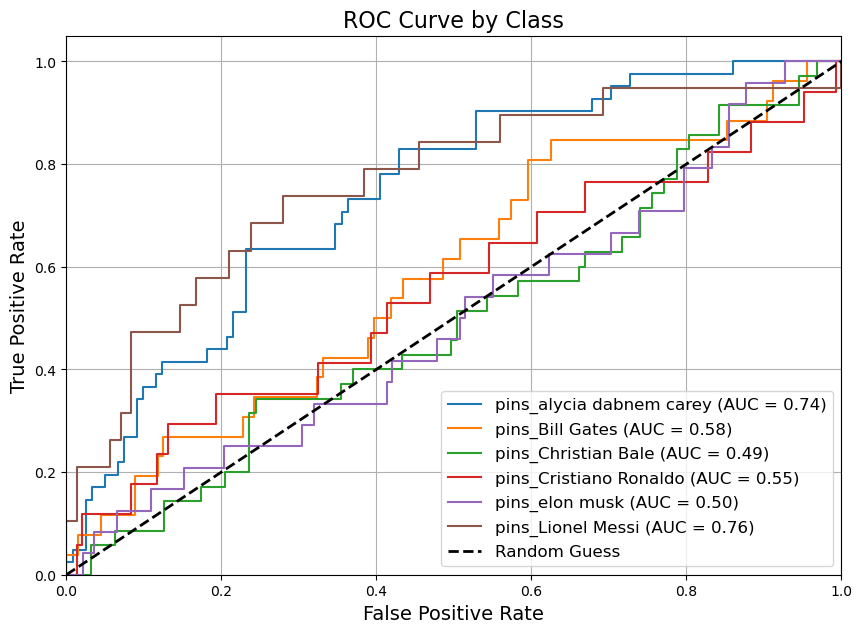

In [22]:
y_true = np.argmax(y_test, axis=1)  # True labels
evaluate_model(y_true, y_preds, y_probs, class_names)